Connected to .venv (Python 3.12.3)

Using CuPy (GPU acceleration)
Using CuPy (GPU acceleration)
Using CuPy (GPU acceleration)
Using CuPy (GPU acceleration)

RUN NAME: synaptic resampling FALSE

Loading MNIST dataset...
Training data shape: (60000, 784), (60000, 10)
Test data shape: (10000, 784), (10000, 10)
Preparing model...
sum of synapses: 2560

parameters: dendrite_mask: 2560.0, dendrite_b: 160, soma_W: 160.0, soma_b: 10
number of model_1 params: 2890

parameters: dendrite_mask: 2560.0, dendrite_b: 160, soma_W: 160.0, soma_b: 10
number of model_2 params: 3000
number of model_3 params: 7850
Dendritic model
Vanilla model



number of mask updates: 1



Training Synaptic Resampling model...


Training : 100%|█████████▉| 5616/5640 [00:10<00:00, 549.10it/s, Epoch=24/24, Batch=234/235, Loss=0.1916]


train loss Synaptic Resampling model 0.1429
train accuracy Synaptic Resampling model 95.6%
test accuracy Synaptic Resampling model 94.7%
Training Base Dendritic model...


Training : 100%|█████████▉| 5616/5640 [00:11<00:00, 486.44it/s, Epoch=24/24, Batch=234/235, Loss=0.2679]


train loss Base Dendritic model 0.231
train accuracy Base Dendritic model 92.9%
test accuracy Base Dendritic model 92.5%
Training Vanilla ANN model...


Training : 100%|█████████▉| 5616/5640 [00:05<00:00, 950.06it/s, Epoch=24/24, Batch=234/235, Loss=0.3132]


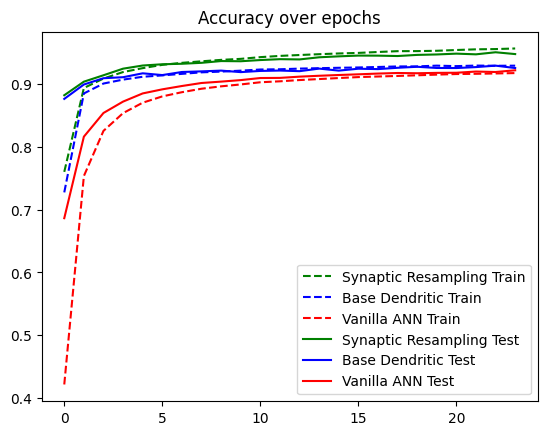

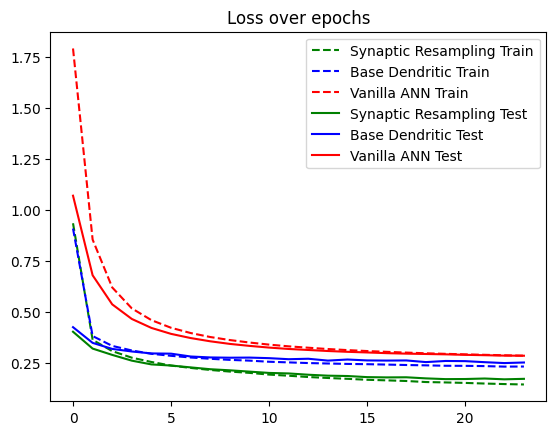

train loss Synaptic Resampling model 0.1429 vs Base Dendritic 0.231 vs Vanilla ANN 0.284
test loss Synaptic Resampling model 0.1706 vs Base Dendritic 0.2507 vs Vanilla ANN 0.2839
train accuracy Synaptic Resampling model 95.6% vs Base Dendritic 92.9% vs Vanilla ANN 91.7%
test accuracy Synaptic Resampling model 94.7% vs Base Dendritic 92.5% vs Vanilla ANN 92.2%
Visualizing 10 neurons, 16 dendrites each
Full Model - Spatial Entropy: 9.1818
Full Model - Weight Value Entropy: 4.7928


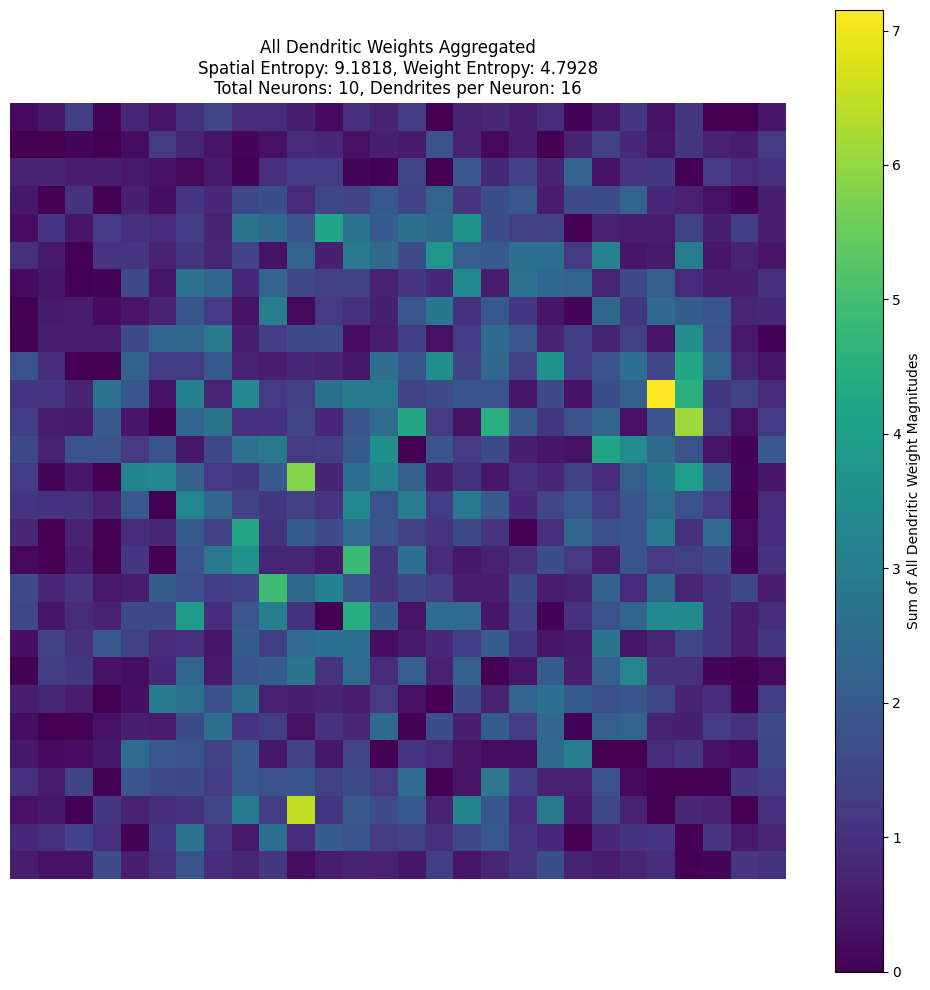

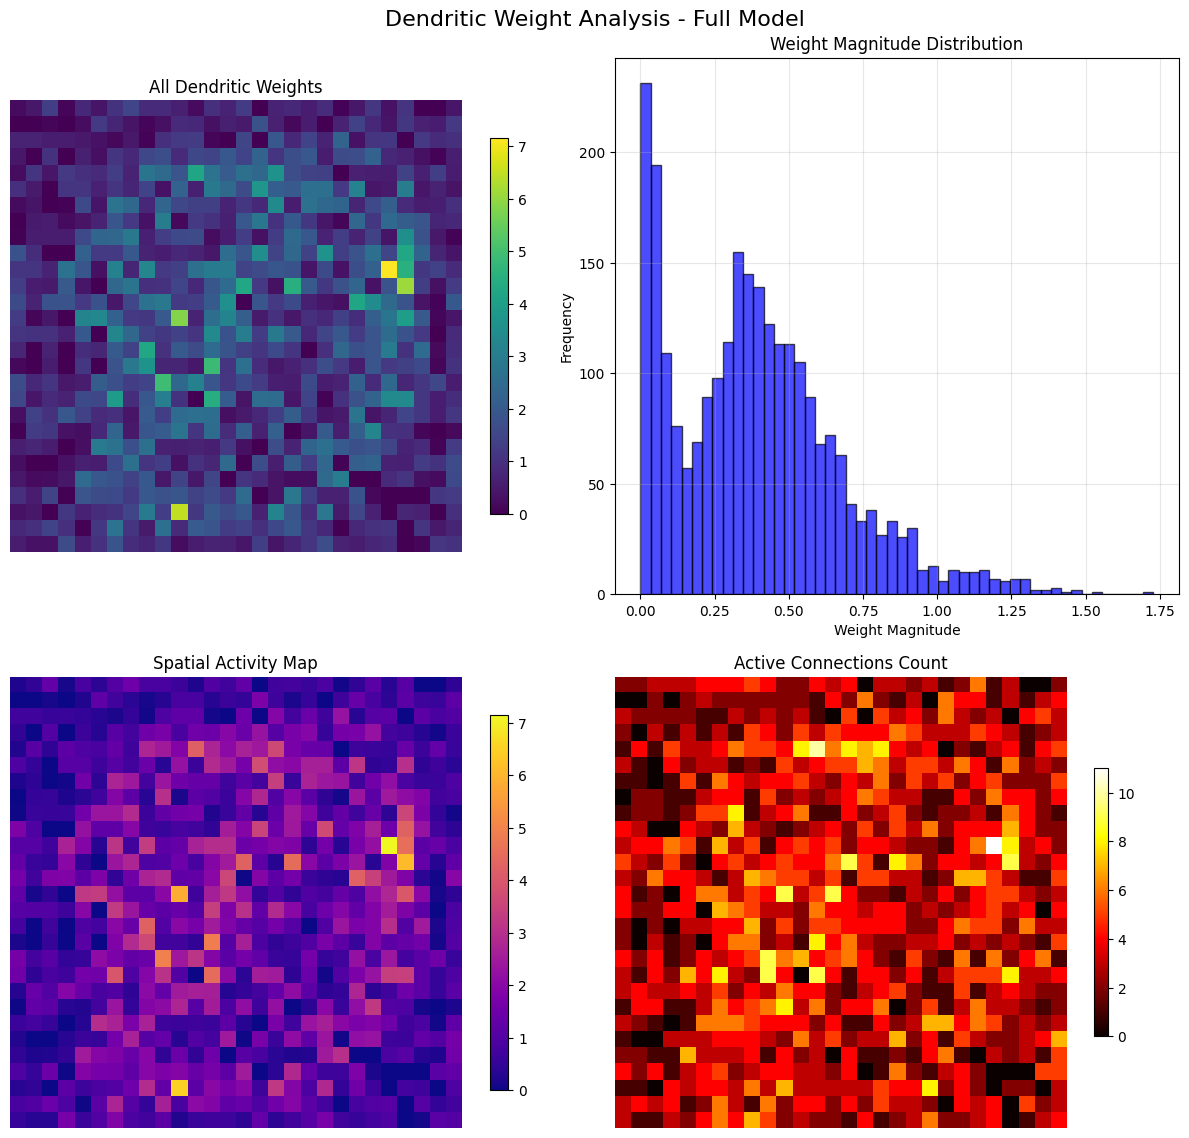


=== Full Model Dendritic Statistics ===
Total parameters: 125440
Active parameters: 2560.0
Sparsity: 0.9796
Mean active weight magnitude: 0.391078
Max weight magnitude: 1.728787
Min non-zero weight magnitude: 0.000218


In [ ]:
try:
    import cupy as cp

    # Test if CuPy can actually access CUDA and random number generator
    cp.cuda.Device(0).compute_capability
    cp.random.seed(1)  # Test if random number generator works
    print("Using CuPy (GPU acceleration)")
except (ImportError, Exception) as e:
    import numpy as cp

    print(f"CuPy not available or CUDA error ({type(e).__name__}), using NumPy (CPU)")

from matplotlib import pyplot as plt
from modules import Adam, CrossEntropy, LeakyReLU, Sequential
from utils import load_mnist_data, load_cifar10_data
from training import (
    compare_models,
    plot_dendritic_weights,
    plot_dendritic_weights_single_image,
    print_network_entropy,
    train,
    train_one_model,
    plot_dendritic_weights_full_model,
)


class LinearLayer:
    """A fully connected, feed forward layer"""

    def __init__(self, in_dim, out_dim):
        self.W = cp.random.randn(out_dim, in_dim) * cp.sqrt(
            2.0 / (in_dim)
        )  # He init, for ReLU
        self.b = cp.zeros(out_dim)
        self.dW = 0.0
        self.db = 0.0
        self.x = None

    def forward(self, x):
        self.x = x
        return x @ self.W.T + self.b

    def backward(self, grad):
        self.dW = grad.T @ self.x
        self.db = grad.sum(axis=0)
        grad = grad @ self.W
        return grad

    def num_params(self):
        return self.W.size + self.b.size

    def var_params(self):
        return cp.var(self.W) + cp.var(self.b)

    def __call__(self, x):
        return self.forward(x)


class DendriticLayer:
    """A sparse dendritic layer, consiting of dendrites and somas"""

    def __init__(
        self,
        in_dim,
        n_neurons,
        strategy="random",
        n_dendrite_inputs=16,
        n_dendrites=4,
        synaptic_resampling=True,
        percentage_resample=0.005,
        scaling_resampling_percentage=False,
        steps_to_resample=100,
        probabilistic_resampling=False,
        local_receptive_field_std_dev_factor=0.5,
        lrf_resampling_prob=0.0,
        dynamic_steps_size=False,
    ):
        assert strategy in ("random", "local-receptive-fields", "fully-connected"), (
            "Invalid strategy"
        )
        self.strategy = strategy
        n_soma_connections = n_dendrites * n_neurons
        self.n_neurons = n_neurons
        self.n_dendrites = n_dendrites
        # dynamicly resample
        self.synaptic_resampling = synaptic_resampling
        self.percentage_resample = percentage_resample
        self.steps_to_resample = steps_to_resample
        self.scaling_resampling_percentage = scaling_resampling_percentage
        self.probabilistic_resampling = probabilistic_resampling
        self.local_receptive_field_std_dev_factor = local_receptive_field_std_dev_factor
        self.lrf_resampling_prob = lrf_resampling_prob
        self.dynamic_steps_size = dynamic_steps_size
        # to keep track of resampling
        self.num_mask_updates = 1
        self.update_steps = 0

        self.in_dim = in_dim
        self.n_dendrite_inputs = n_dendrite_inputs
        self.dendrite_W = cp.random.randn(n_soma_connections, in_dim) * cp.sqrt(
            2.0 / (in_dim)
        )  # He init, for ReLU
        self.dendrite_b = cp.zeros((n_soma_connections))
        self.dendrite_dW = 0.0
        self.dendrite_db = 0.0
        self.dendrite_activation = LeakyReLU()

        self.soma_W = cp.random.randn(n_neurons, n_soma_connections) * cp.sqrt(
            2.0 / (n_soma_connections)
        )  # He init, for ReLU
        self.soma_b = cp.zeros(n_neurons)
        self.soma_dW = 0.0
        self.soma_db = 0.0
        self.soma_activation = LeakyReLU()

        # inputs to save for backprop
        self.dendrite_x = None
        self.soma_x = None

        # sample soma mask:
        # [[1, 1, 0, 0]
        #  [0, 0, 1, 1]]
        # number of 1 per row is n_dendrites, rest 0. every column only has 1 entry
        # number of rows equals n_neurons, number of columns eqais n_soma_connections
        # it is a step pattern, so the first n_dendrites entries of the first row are one.
        self.soma_mask = cp.zeros((n_neurons, n_soma_connections))
        for i in range(n_neurons):
            start_idx = i * n_dendrites
            end_idx = start_idx + n_dendrites
            self.soma_mask[i, start_idx:end_idx] = 1

        # mask out unneeded weights, thus making weights sparse
        self.soma_W = self.soma_W * self.soma_mask

        # sample dendrite mask
        # for each dendrite sample n_dendrite_inputs from the input array
        self.dendrite_mask = cp.zeros((n_soma_connections, in_dim))
        for i in range(n_soma_connections):
            if strategy == "random":
                # sample without replacement from possible input for a given dendrite from the whole input
                input_idx = cp.random.choice(
                    cp.arange(in_dim), size=n_dendrite_inputs, replace=False
                )
            elif strategy == "local-receptive-fields":
                # According to the description: "16 inputs are chosen from the 4 × 4 neighborhood"
                input_idx = self.create_local_receptive_field_mask()
            elif strategy == "fully-connected":
                # sample all inputs for a given dendrite
                input_idx = cp.arange(in_dim)
            self.dendrite_mask[i, input_idx] = 1

        # mask out unneeded weights, thus making weights sparse
        self.dendrite_W = self.dendrite_W * self.dendrite_mask

    def create_local_receptive_field_mask(self):
        image_size = int(cp.sqrt(self.in_dim))

        # Choose a center pixel randomly from the image
        center_row = cp.random.randint(0, image_size)
        center_col = cp.random.randint(0, image_size)

        # The standard deviation is the square root of n_dendrite_inputs
        std_dev = cp.power(
            self.n_dendrite_inputs, self.local_receptive_field_std_dev_factor
        )

        # Use a set to store unique indices, starting with the center pixel
        center_idx = (center_row * image_size + center_col).item()
        sampled_indices = {center_idx}

        # Sample until we have n_dendrite_inputs
        while len(sampled_indices) < self.n_dendrite_inputs:
            # Sample one point from a Gaussian distribution around the center
            row_offset = cp.random.normal(loc=0.0, scale=std_dev)
            col_offset = cp.random.normal(loc=0.0, scale=std_dev)

            sampled_row = cp.round(center_row + row_offset)
            sampled_col = cp.round(center_col + col_offset)

            # Clip coordinates to be within image bounds
            sampled_row = cp.clip(sampled_row, 0, image_size - 1)
            sampled_col = cp.clip(sampled_col, 0, image_size - 1)

            # Convert to 1D index and add to set
            idx = sampled_row.item() * image_size + sampled_col.item()
            sampled_indices.add(idx)

        input_idx = cp.array(list(sampled_indices), dtype=int)
        return input_idx

    def forward(self, x):
        # dendrites forward pass
        self.dendrite_x = x
        x = x @ self.dendrite_W.T + self.dendrite_b
        x = self.dendrite_activation(x)

        # soma forward pass
        self.soma_x = x
        x = x @ self.soma_W.T + self.soma_b
        x = self.soma_activation(x)
        return x

    def backward(self, grad):
        grad = self.soma_activation.backward(grad)

        # soma back pass, multiply with mask to keep only valid gradients
        self.soma_dW = grad.T @ self.soma_x * self.soma_mask
        self.soma_db = grad.sum(axis=0)
        soma_grad = grad @ self.soma_W

        soma_grad = self.dendrite_activation.backward(soma_grad)

        # dendrite back pass
        self.dendrite_dW = soma_grad.T @ self.dendrite_x * self.dendrite_mask
        self.dendrite_db = soma_grad.sum(axis=0)
        dendrite_grad = soma_grad @ self.dendrite_W

        if self.synaptic_resampling:
            self.update_steps += 1

            # if enough steps have passed, resample
            if self.dynamic_steps_size:
                resample_bool = self.update_steps >= 100 + 5 * self.num_mask_updates
                # resample_bool = self.update_steps >= cp.exp((self.num_mask_updates + 20) / 10 ) + 20
            else:
                # resample_bool = self.update_steps >= 20 + 10 * self.num_mask_updates
                resample_bool = self.update_steps >= self.steps_to_resample
                # and self.num_mask_updates < 500
                # if self.update_steps == 500:
                # print("LAST UPDATE")
            if resample_bool:
                # reset step counter
                self.update_steps = 0
                self.resample_dendrites()

        # Ensure dendrite weights stay masked to maintain constant synapse count
        self.dendrite_W = self.dendrite_W * self.dendrite_mask

        return dendrite_grad

    def _lrf_resample(self, dendrites_to_resample):
        """Resample connections for specified dendrites using a local receptive field approach."""
        image_size = int(cp.sqrt(self.in_dim))
        n_to_resample = dendrites_to_resample.size

        # --- 1. Find the center of each unique dendrite's receptive field ---
        unique_dendrites, inverse_indices = cp.unique(
            dendrites_to_resample, return_inverse=True
        )

        # Get all connections for the unique dendrites that need resampling
        dendrite_masks = self.dendrite_mask[unique_dendrites, :]
        connected_indices = cp.where(dendrite_masks)

        # `connected_indices[0]` maps an entry to an index in `unique_dendrites`
        # `connected_indices[1]` is the input feature index (1D)
        unique_dendrite_map = connected_indices[0]
        input_feature_indices = connected_indices[1]

        # Convert 1D input indices to 2D coordinates to calculate centers
        rows_2d = input_feature_indices // image_size
        cols_2d = input_feature_indices % image_size

        # Calculate the mean row and column for each unique dendrite (vectorized groupby)
        dendrite_counts = cp.bincount(unique_dendrite_map)
        center_rows = (
            cp.bincount(unique_dendrite_map, weights=rows_2d) / dendrite_counts
        )
        center_cols = (
            cp.bincount(unique_dendrite_map, weights=cols_2d) / dendrite_counts
        )

        # --- 2. Map centers back to the original `dendrites_to_resample` list ---
        # This gives us a center for each connection we need to create
        resample_center_rows = center_rows[inverse_indices]
        resample_center_cols = center_cols[inverse_indices]

        # --- 3. Sample new connections from a Gaussian distribution around the centers ---
        std_dev = cp.power(
            self.n_dendrite_inputs, self.local_receptive_field_std_dev_factor
        )

        row_offsets = cp.random.normal(loc=0.0, scale=std_dev, size=n_to_resample)
        col_offsets = cp.random.normal(loc=0.0, scale=std_dev, size=n_to_resample)

        new_rows = cp.round(resample_center_rows + row_offsets)
        new_cols = cp.round(resample_center_cols + col_offsets)

        # Clip coordinates to be within image bounds
        new_rows = cp.clip(new_rows, 0, image_size - 1)
        new_cols = cp.clip(new_cols, 0, image_size - 1)

        # Convert 2D coordinates back to 1D indices
        new_input_indices = new_rows * image_size + new_cols

        return new_input_indices.astype(int)

    def resample_dendrites(self):
        # --- Part 1: Connection Removal ---
        if self.probabilistic_resampling:
            # --- Probabilistic pruning based on weight magnitude ---
            P_MAX_PRUNE = 0.95
            THRESHOLD_W = 0.6
            STEEPNESS = 0.1
            # P_MAX_PRUNE = 0.95
            # THRESHOLD_W = 0.5
            # STEEPNESS = 0.1 with 100

            w_abs = cp.abs(self.dendrite_W)
            # Sigmoid-based pruning probability
            prune_probabilities = P_MAX_PRUNE / (
                1 + cp.exp((w_abs - THRESHOLD_W) / STEEPNESS)
            )

            # Probabilistically decide which connections to prune.
            should_prune_mask = (
                cp.random.random(self.dendrite_W.shape) < prune_probabilities
            ) & (self.dendrite_mask == 1)

            rows_to_remove, cols_to_remove = cp.where(should_prune_mask)

            if rows_to_remove.size == 0:
                # print("num of dendrite successful swaps: 0")
                return

            removed_dendrite_indices = rows_to_remove
            removed_input_indices = cols_to_remove
        else:
            # --- Flat-rate pruning ---
            if self.scaling_resampling_percentage:
                resampling_percentage = 1 / (1 + 0.1 * self.num_mask_updates)
            else:
                resampling_percentage = self.percentage_resample

            n_to_remove_per_dendrite = int(
                self.n_dendrite_inputs * resampling_percentage
            )
            if n_to_remove_per_dendrite == 0:
                return

            num_dendrites = self.dendrite_mask.shape[0]

            # For magnitude, we remove the smallest. Set inactive connections to infinity so they are not picked.
            metric = cp.abs(self.dendrite_W)
            metric[self.dendrite_mask == 0] = cp.inf
            sorted_indices = cp.argsort(metric, axis=1)
            cols_to_remove = sorted_indices[:, :n_to_remove_per_dendrite]

            # Create corresponding row indices and flatten for the swap logic
            rows_to_remove = cp.arange(num_dendrites)[:, cp.newaxis]
            removed_dendrite_indices = rows_to_remove.repeat(
                n_to_remove_per_dendrite, axis=1
            ).flatten()
            removed_input_indices = cols_to_remove.flatten()

        n_connections_to_remove = removed_dendrite_indices.size

        # --- Part 2: One-shot Resampling Attempt ---
        num_inputs_per_dendrite = self.dendrite_x.shape[1]

        # Decide whether to use LRF or random resampling
        use_lrf = (
            self.strategy == "local-receptive-fields"
            and cp.random.random() < self.lrf_resampling_prob
        )

        if use_lrf and n_connections_to_remove > 0:
            newly_selected_input_indices = self._lrf_resample(removed_dendrite_indices)
        else:
            newly_selected_input_indices = cp.random.randint(
                0, num_inputs_per_dendrite, size=n_connections_to_remove, dtype=int
            )

        # --- Part 3: Conflict Detection ---
        conflict_with_existing = (
            self.dendrite_mask[removed_dendrite_indices, newly_selected_input_indices]
            == 1
        )

        num_dendrites = self.dendrite_mask.shape[0]
        proposed_flat_indices = (
            removed_dendrite_indices * num_inputs_per_dendrite
            + newly_selected_input_indices
        )
        counts = cp.bincount(
            proposed_flat_indices.astype(int),
            minlength=num_dendrites * num_inputs_per_dendrite,
        )
        is_duplicate_flat = counts[proposed_flat_indices.astype(int)] > 1

        is_problematic = conflict_with_existing | is_duplicate_flat
        is_successful = ~is_problematic

        # --- Part 4: Apply Successful Swaps ---
        dendrites_to_swap = removed_dendrite_indices[is_successful]
        old_inputs_to_remove = removed_input_indices[is_successful]
        new_inputs_to_add = newly_selected_input_indices[is_successful]

        if dendrites_to_swap.size > 0:
            self.dendrite_mask[dendrites_to_swap, old_inputs_to_remove] = 0
            self.dendrite_mask[dendrites_to_swap, new_inputs_to_add] = 1

            self.dendrite_W[dendrites_to_swap, new_inputs_to_add] = cp.random.randn(
                dendrites_to_swap.shape[0]
            ) * cp.sqrt(2.0 / self.in_dim)

        self.dendrite_W = self.dendrite_W * self.dendrite_mask

        # print(f"num of dendrite successful swaps: {dendrites_to_swap.size}")

        self.num_mask_updates += 1

        # --- Part 5: Verification ---
        connections_per_dendrite = cp.sum(self.dendrite_mask, axis=1)
        assert cp.all(connections_per_dendrite == self.n_dendrite_inputs), (
            f"Resampling failed: not all dendrites have {self.n_dendrite_inputs} connections."
        )

    def num_params(self):
        print(
            f"\nparameters: dendrite_mask: {cp.sum(self.dendrite_mask)}, dendrite_b: {self.dendrite_b.size}, soma_W: {cp.sum(self.soma_mask)}, soma_b: {self.soma_b.size}"
        )
        return int(
            cp.sum(self.dendrite_mask)
            + self.dendrite_b.size
            + cp.sum(self.soma_mask)
            + self.soma_b.size
        )

    def var_params(self):
        return (
            cp.var(self.dendrite_W)
            + cp.var(self.dendrite_b)
            + cp.var(self.soma_W)
            + cp.var(self.soma_b)
        )

    def __call__(self, x):
        return self.forward(x)


def main():
    pass


# for repoducability
cp.random.seed(123123)

# data config
dataset = "mnist"  # "mnist", "fashion-mnist", "cifar10"
subset_size = None

# config
n_epochs = 24  # 15 MNIST, 20 Fashion-MNIST
lr = 0.003  # 0.003
v_lr = 0.0001  # 0.015 - SGD
b_lr = 0.003  # 0.015 - SGD
weight_decay = 0.01  # 0.001
batch_size = 256
n_classes = 10

if dataset in ["mnist", "fashion-mnist"]:
    in_dim = 28 * 28  # Image dimensions (28x28 MNIST, 32x32x3 CIFAR-10)
elif dataset == "cifar10":
    in_dim = 32 * 32 * 3
else:
    raise ValueError(f"Invalid dataset: {dataset}")

# dendriticmodel config
n_dendrite_inputs = 16
n_dendrites = 16
n_neurons = 10
strategy = "random"  # ["random", "local-receptive-fields", "fully-connected"]

print("\nRUN NAME: synaptic resampling FALSE\n")

if dataset in ["mnist", "fashion-mnist"]:
    X_train, y_train, X_test, y_test = load_mnist_data(
        dataset=dataset, subset_size=subset_size
    )
elif dataset == "cifar10":
    X_train, y_train, X_test, y_test = load_cifar10_data(subset_size=subset_size)

print("Preparing model...")
criterion = CrossEntropy()
model = Sequential(
    [
        DendriticLayer(
            in_dim,
            n_neurons,
            n_dendrite_inputs=n_dendrite_inputs,
            n_dendrites=n_dendrites,
            strategy=strategy,
            synaptic_resampling=True,
            percentage_resample=0.25,
            steps_to_resample=100,
            scaling_resampling_percentage=False,
            dynamic_steps_size=False,
        ),
        # LeakyReLU(),
        # LinearLayer(n_neurons, n_classes),
    ]
)
optimiser = Adam(
    model.params(), criterion, lr=lr, weight_decay=weight_decay, grad_clip=0.1
)

# train_one_model(
#     X_train,
#     y_train,
#     X_test,
#     y_test,
#     model,
#     criterion,
#     optimiser,
#     n_epochs=n_epochs,
#     batch_size=batch_size,
# )

# plot_dendritic_weights_full_model(model, X_test[0])
# for i in range(10):
# plot_dendritic_weights_single_image(model, X_test[0], neuron_idx=i)

sum_of_synapses = cp.count_nonzero(model.layers[0].dendrite_W)
print(f"sum of synapses: {sum_of_synapses}")


# baseline dendritic model
b_criterion = CrossEntropy()
b_model = Sequential(
    [
        DendriticLayer(
            in_dim,
            n_neurons,
            n_dendrite_inputs=n_dendrite_inputs,
            n_dendrites=n_dendrites,
            strategy=strategy,
            synaptic_resampling=False,
        ),
        LeakyReLU(),
        LinearLayer(n_neurons, n_classes),
    ]
)
b_optimiser = Adam(b_model.params(), b_criterion, lr=b_lr, weight_decay=weight_decay)

# vanilla model
v_criterion = CrossEntropy()
v_model = Sequential(
    [
        LinearLayer(in_dim, 10),
        # LeakyReLU(),
        # LinearLayer(12, 10),
        # LeakyReLU(),
        # LinearLayer(10, n_classes),
    ]
)
v_optimiser = Adam(v_model.params(), v_criterion, lr=v_lr, weight_decay=weight_decay)

print(f"number of model_1 params: {model.num_params()}")
print(f"number of model_2 params: {b_model.num_params()}")
print(f"number of model_3 params: {v_model.num_params()}")

print("Dendritic model")
# print_network_entropy(model)
print("Vanilla model")
# print_network_entropy(v_model)

# raise Exception("Stop here")

print("\n\n")
print(f"number of mask updates: {model.layers[0].num_mask_updates}")
# print(f"number of mask updates baseline model: {v_model.layers[0].num_mask_updates}")
print("\n\n")

compare_models(
    model,
    b_model,
    v_model,
    optimiser,
    b_optimiser,
    v_optimiser,
    X_train,
    y_train,
    X_test,
    y_test,
    criterion,
    n_epochs=n_epochs,
    batch_size=batch_size,
    model_name_1="Synaptic Resampling",
    model_name_2="Base Dendritic",
    model_name_3="Vanilla ANN",
    track_variance=False,
)

# print("Dendritic model")
# print_network_entropy(model)
# print("Vanilla model")
# print_network_entropy(v_model)

# print("\n\n")
# print(f"number of mask updates: {model.layers[0].num_mask_updates}")
# print(f"number of mask updates baseline model: {v_model.layers[0].num_mask_updates}")
# print("\n\n")

# Visualize the weights of the first neuron in the dendritic model
# print("\nVisualizing dendritic weights for the first neuron of the dendritic model...")
# # plot_dendritic_weights(model, X_test[0], neuron_idx=0)
# plot_dendritic_weights_single_image(model, X_test[0], neuron_idx=0)
# print("Vanilla model")
# for i in range(10):
# print(i)
# plot_dendritic_weights_single_image(model, X_test[0], neuron_idx=i)


# # %%
plot_dendritic_weights_full_model(model, X_test[0])

# if __name__ == "__main__":
#     main()

Using CuPy (GPU acceleration)

RUN NAME: synaptic resampling FALSE

Loading MNIST dataset...
Training data shape: (60000, 784), (60000, 10)
Test data shape: (10000, 784), (10000, 10)
Preparing model...
sum of synapses: 2560

parameters: dendrite_mask: 2560.0, dendrite_b: 160, soma_W: 160.0, soma_b: 10
number of model_1 params: 2890

parameters: dendrite_mask: 2560.0, dendrite_b: 160, soma_W: 160.0, soma_b: 10
number of model_2 params: 3000
number of model_3 params: 7850
Dendritic model
Vanilla model



number of mask updates: 1



Training Synaptic Resampling model...


Training : 100%|█████████▉| 5616/5640 [00:10<00:00, 555.55it/s, Epoch=24/24, Batch=234/235, Loss=0.1916]


train loss Synaptic Resampling model 0.1429
train accuracy Synaptic Resampling model 95.6%
test accuracy Synaptic Resampling model 94.7%
Training Base Dendritic model...


Training : 100%|█████████▉| 5616/5640 [00:11<00:00, 486.76it/s, Epoch=24/24, Batch=234/235, Loss=0.2679]


train loss Base Dendritic model 0.231
train accuracy Base Dendritic model 92.9%
test accuracy Base Dendritic model 92.5%
Training Vanilla ANN model...


Training : 100%|█████████▉| 5616/5640 [00:05<00:00, 946.57it/s, Epoch=24/24, Batch=234/235, Loss=0.3132]


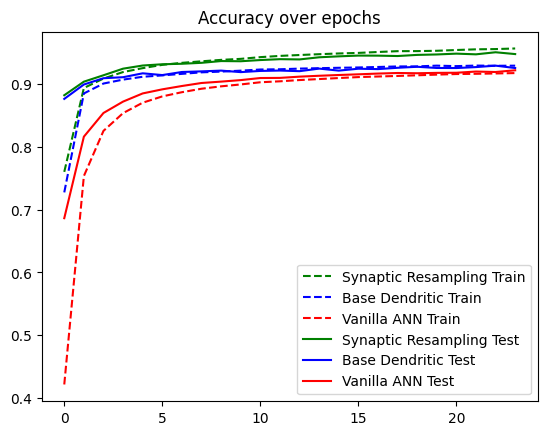

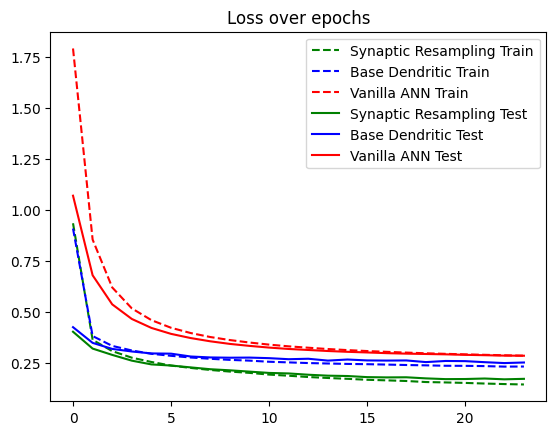

train loss Synaptic Resampling model 0.1429 vs Base Dendritic 0.231 vs Vanilla ANN 0.284
test loss Synaptic Resampling model 0.1706 vs Base Dendritic 0.2507 vs Vanilla ANN 0.2839
train accuracy Synaptic Resampling model 95.6% vs Base Dendritic 92.9% vs Vanilla ANN 91.7%
test accuracy Synaptic Resampling model 94.7% vs Base Dendritic 92.5% vs Vanilla ANN 92.2%
Visualizing 10 neurons, 16 dendrites each
Full Model - Spatial Entropy: 9.1818
Full Model - Weight Value Entropy: 4.7928


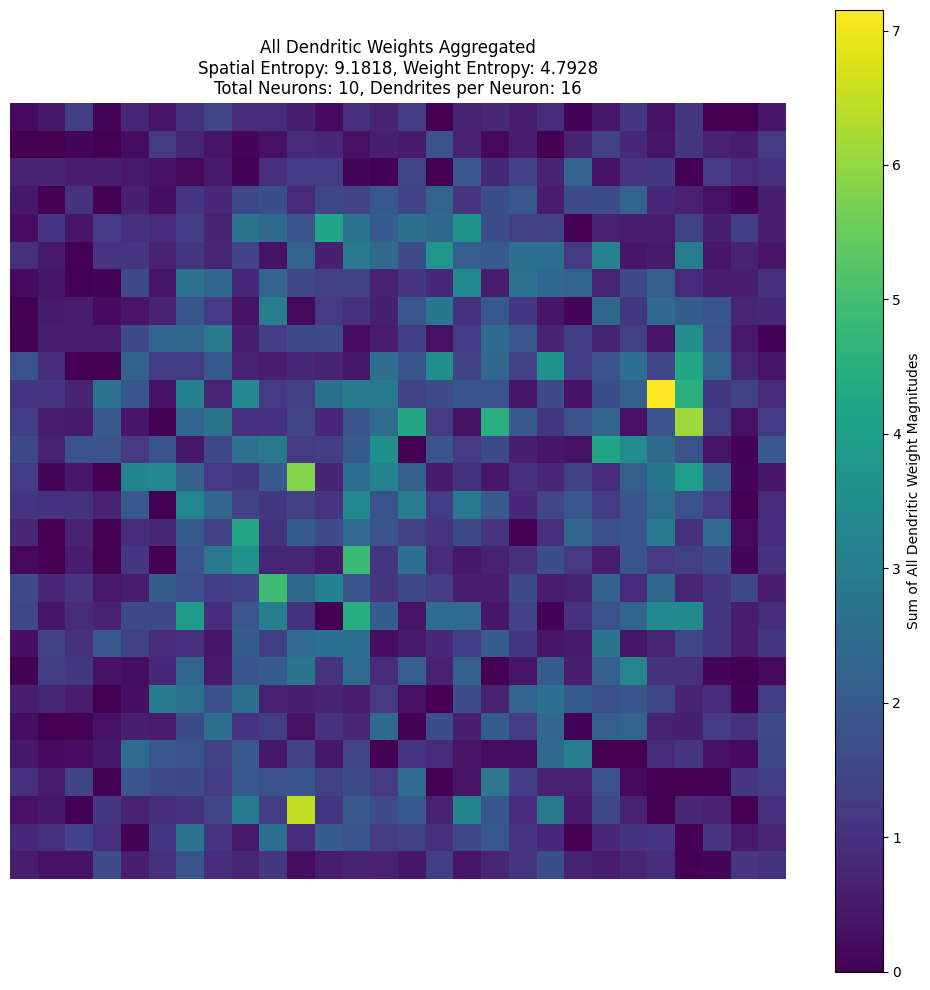

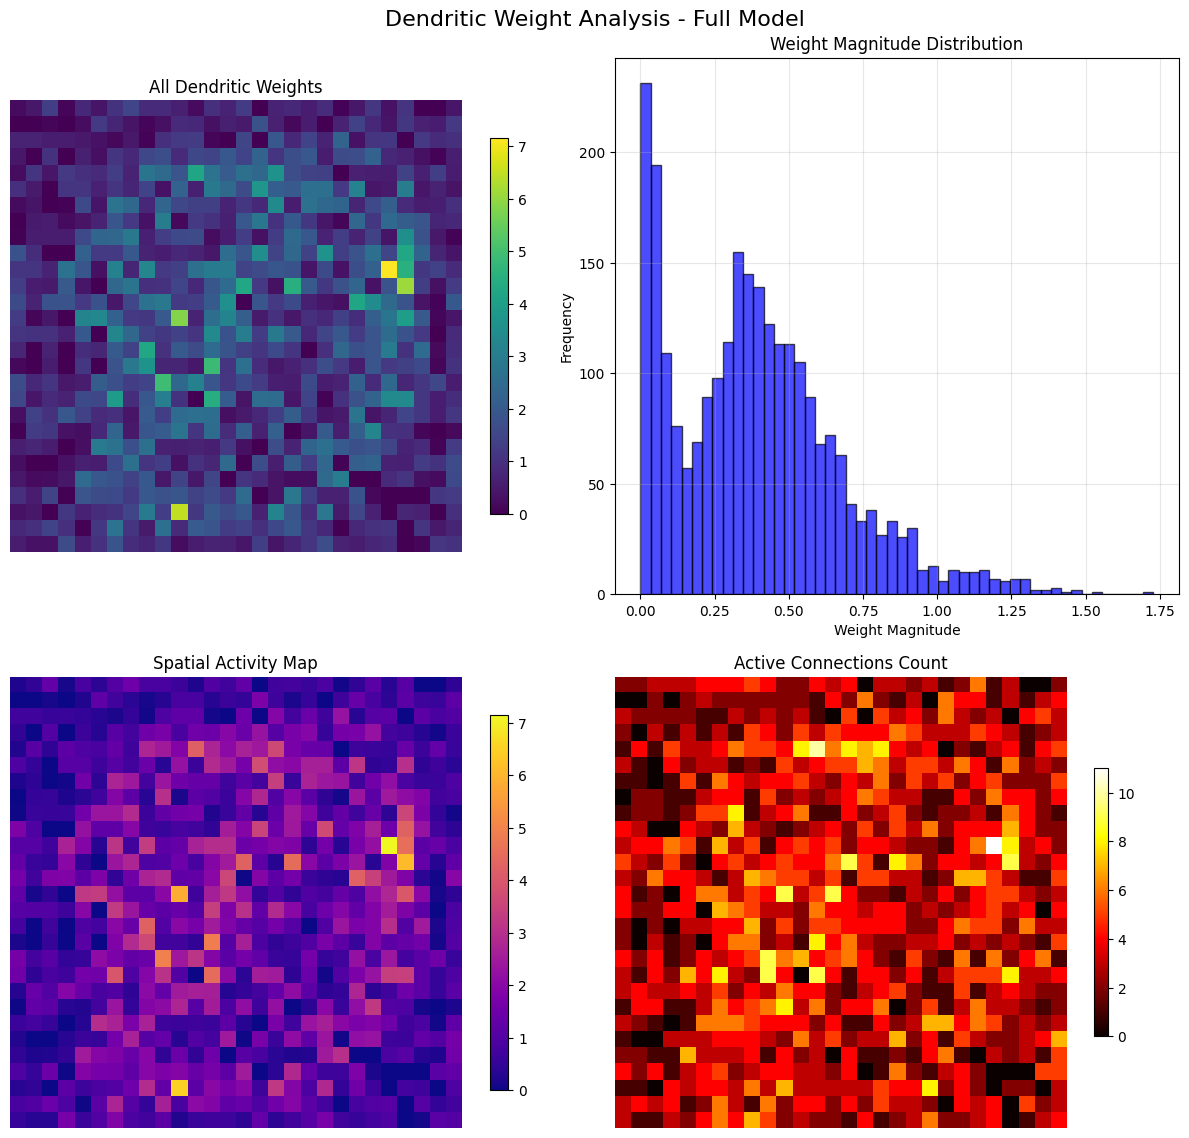


=== Full Model Dendritic Statistics ===
Total parameters: 125440
Active parameters: 2560.0
Sparsity: 0.9796
Mean active weight magnitude: 0.391078
Max weight magnitude: 1.728787
Min non-zero weight magnitude: 0.000218


In [ ]:
try:
    import cupy as cp

    # Test if CuPy can actually access CUDA and random number generator
    cp.cuda.Device(0).compute_capability
    cp.random.seed(1)  # Test if random number generator works
    print("Using CuPy (GPU acceleration)")
except (ImportError, Exception) as e:
    import numpy as cp

    print(f"CuPy not available or CUDA error ({type(e).__name__}), using NumPy (CPU)")

from matplotlib import pyplot as plt
from modules import Adam, CrossEntropy, LeakyReLU, Sequential
from utils import load_mnist_data, load_cifar10_data
from training import (
    compare_models,
    plot_dendritic_weights,
    plot_dendritic_weights_single_image,
    print_network_entropy,
    train,
    train_one_model,
    plot_dendritic_weights_full_model,
)


class LinearLayer:
    """A fully connected, feed forward layer"""

    def __init__(self, in_dim, out_dim):
        self.W = cp.random.randn(out_dim, in_dim) * cp.sqrt(
            2.0 / (in_dim)
        )  # He init, for ReLU
        self.b = cp.zeros(out_dim)
        self.dW = 0.0
        self.db = 0.0
        self.x = None

    def forward(self, x):
        self.x = x
        return x @ self.W.T + self.b

    def backward(self, grad):
        self.dW = grad.T @ self.x
        self.db = grad.sum(axis=0)
        grad = grad @ self.W
        return grad

    def num_params(self):
        return self.W.size + self.b.size

    def var_params(self):
        return cp.var(self.W) + cp.var(self.b)

    def __call__(self, x):
        return self.forward(x)


class DendriticLayer:
    """A sparse dendritic layer, consiting of dendrites and somas"""

    def __init__(
        self,
        in_dim,
        n_neurons,
        strategy="random",
        n_dendrite_inputs=16,
        n_dendrites=4,
        synaptic_resampling=True,
        percentage_resample=0.005,
        scaling_resampling_percentage=False,
        steps_to_resample=100,
        probabilistic_resampling=False,
        local_receptive_field_std_dev_factor=0.5,
        lrf_resampling_prob=0.0,
        dynamic_steps_size=False,
    ):
        assert strategy in ("random", "local-receptive-fields", "fully-connected"), (
            "Invalid strategy"
        )
        self.strategy = strategy
        n_soma_connections = n_dendrites * n_neurons
        self.n_neurons = n_neurons
        self.n_dendrites = n_dendrites
        # dynamicly resample
        self.synaptic_resampling = synaptic_resampling
        self.percentage_resample = percentage_resample
        self.steps_to_resample = steps_to_resample
        self.scaling_resampling_percentage = scaling_resampling_percentage
        self.probabilistic_resampling = probabilistic_resampling
        self.local_receptive_field_std_dev_factor = local_receptive_field_std_dev_factor
        self.lrf_resampling_prob = lrf_resampling_prob
        self.dynamic_steps_size = dynamic_steps_size
        # to keep track of resampling
        self.num_mask_updates = 1
        self.update_steps = 0

        self.in_dim = in_dim
        self.n_dendrite_inputs = n_dendrite_inputs
        self.dendrite_W = cp.random.randn(n_soma_connections, in_dim) * cp.sqrt(
            2.0 / (in_dim)
        )  # He init, for ReLU
        self.dendrite_b = cp.zeros((n_soma_connections))
        self.dendrite_dW = 0.0
        self.dendrite_db = 0.0
        self.dendrite_activation = LeakyReLU()

        self.soma_W = cp.random.randn(n_neurons, n_soma_connections) * cp.sqrt(
            2.0 / (n_soma_connections)
        )  # He init, for ReLU
        self.soma_b = cp.zeros(n_neurons)
        self.soma_dW = 0.0
        self.soma_db = 0.0
        self.soma_activation = LeakyReLU()

        # inputs to save for backprop
        self.dendrite_x = None
        self.soma_x = None

        # sample soma mask:
        # [[1, 1, 0, 0]
        #  [0, 0, 1, 1]]
        # number of 1 per row is n_dendrites, rest 0. every column only has 1 entry
        # number of rows equals n_neurons, number of columns eqais n_soma_connections
        # it is a step pattern, so the first n_dendrites entries of the first row are one.
        self.soma_mask = cp.zeros((n_neurons, n_soma_connections))
        for i in range(n_neurons):
            start_idx = i * n_dendrites
            end_idx = start_idx + n_dendrites
            self.soma_mask[i, start_idx:end_idx] = 1

        # mask out unneeded weights, thus making weights sparse
        self.soma_W = self.soma_W * self.soma_mask

        # sample dendrite mask
        # for each dendrite sample n_dendrite_inputs from the input array
        self.dendrite_mask = cp.zeros((n_soma_connections, in_dim))
        for i in range(n_soma_connections):
            if strategy == "random":
                # sample without replacement from possible input for a given dendrite from the whole input
                input_idx = cp.random.choice(
                    cp.arange(in_dim), size=n_dendrite_inputs, replace=False
                )
            elif strategy == "local-receptive-fields":
                # According to the description: "16 inputs are chosen from the 4 × 4 neighborhood"
                input_idx = self.create_local_receptive_field_mask()
            elif strategy == "fully-connected":
                # sample all inputs for a given dendrite
                input_idx = cp.arange(in_dim)
            self.dendrite_mask[i, input_idx] = 1

        # mask out unneeded weights, thus making weights sparse
        self.dendrite_W = self.dendrite_W * self.dendrite_mask

    def create_local_receptive_field_mask(self):
        image_size = int(cp.sqrt(self.in_dim))

        # Choose a center pixel randomly from the image
        center_row = cp.random.randint(0, image_size)
        center_col = cp.random.randint(0, image_size)

        # The standard deviation is the square root of n_dendrite_inputs
        std_dev = cp.power(
            self.n_dendrite_inputs, self.local_receptive_field_std_dev_factor
        )

        # Use a set to store unique indices, starting with the center pixel
        center_idx = (center_row * image_size + center_col).item()
        sampled_indices = {center_idx}

        # Sample until we have n_dendrite_inputs
        while len(sampled_indices) < self.n_dendrite_inputs:
            # Sample one point from a Gaussian distribution around the center
            row_offset = cp.random.normal(loc=0.0, scale=std_dev)
            col_offset = cp.random.normal(loc=0.0, scale=std_dev)

            sampled_row = cp.round(center_row + row_offset)
            sampled_col = cp.round(center_col + col_offset)

            # Clip coordinates to be within image bounds
            sampled_row = cp.clip(sampled_row, 0, image_size - 1)
            sampled_col = cp.clip(sampled_col, 0, image_size - 1)

            # Convert to 1D index and add to set
            idx = sampled_row.item() * image_size + sampled_col.item()
            sampled_indices.add(idx)

        input_idx = cp.array(list(sampled_indices), dtype=int)
        return input_idx

    def forward(self, x):
        # dendrites forward pass
        self.dendrite_x = x
        x = x @ self.dendrite_W.T + self.dendrite_b
        x = self.dendrite_activation(x)

        # soma forward pass
        self.soma_x = x
        x = x @ self.soma_W.T + self.soma_b
        x = self.soma_activation(x)
        return x

    def backward(self, grad):
        grad = self.soma_activation.backward(grad)

        # soma back pass, multiply with mask to keep only valid gradients
        self.soma_dW = grad.T @ self.soma_x * self.soma_mask
        self.soma_db = grad.sum(axis=0)
        soma_grad = grad @ self.soma_W

        soma_grad = self.dendrite_activation.backward(soma_grad)

        # dendrite back pass
        self.dendrite_dW = soma_grad.T @ self.dendrite_x * self.dendrite_mask
        self.dendrite_db = soma_grad.sum(axis=0)
        dendrite_grad = soma_grad @ self.dendrite_W

        if self.synaptic_resampling:
            self.update_steps += 1

            # if enough steps have passed, resample
            if self.dynamic_steps_size:
                resample_bool = self.update_steps >= 100 + 5 * self.num_mask_updates
                # resample_bool = self.update_steps >= cp.exp((self.num_mask_updates + 20) / 10 ) + 20
            else:
                # resample_bool = self.update_steps >= 20 + 10 * self.num_mask_updates
                resample_bool = self.update_steps >= self.steps_to_resample
                # and self.num_mask_updates < 500
                # if self.update_steps == 500:
                # print("LAST UPDATE")
            if resample_bool:
                # reset step counter
                self.update_steps = 0
                self.resample_dendrites()

        # Ensure dendrite weights stay masked to maintain constant synapse count
        self.dendrite_W = self.dendrite_W * self.dendrite_mask

        return dendrite_grad

    def _lrf_resample(self, dendrites_to_resample):
        """Resample connections for specified dendrites using a local receptive field approach."""
        image_size = int(cp.sqrt(self.in_dim))
        n_to_resample = dendrites_to_resample.size

        # --- 1. Find the center of each unique dendrite's receptive field ---
        unique_dendrites, inverse_indices = cp.unique(
            dendrites_to_resample, return_inverse=True
        )

        # Get all connections for the unique dendrites that need resampling
        dendrite_masks = self.dendrite_mask[unique_dendrites, :]
        connected_indices = cp.where(dendrite_masks)

        # `connected_indices[0]` maps an entry to an index in `unique_dendrites`
        # `connected_indices[1]` is the input feature index (1D)
        unique_dendrite_map = connected_indices[0]
        input_feature_indices = connected_indices[1]

        # Convert 1D input indices to 2D coordinates to calculate centers
        rows_2d = input_feature_indices // image_size
        cols_2d = input_feature_indices % image_size

        # Calculate the mean row and column for each unique dendrite (vectorized groupby)
        dendrite_counts = cp.bincount(unique_dendrite_map)
        center_rows = (
            cp.bincount(unique_dendrite_map, weights=rows_2d) / dendrite_counts
        )
        center_cols = (
            cp.bincount(unique_dendrite_map, weights=cols_2d) / dendrite_counts
        )

        # --- 2. Map centers back to the original `dendrites_to_resample` list ---
        # This gives us a center for each connection we need to create
        resample_center_rows = center_rows[inverse_indices]
        resample_center_cols = center_cols[inverse_indices]

        # --- 3. Sample new connections from a Gaussian distribution around the centers ---
        std_dev = cp.power(
            self.n_dendrite_inputs, self.local_receptive_field_std_dev_factor
        )

        row_offsets = cp.random.normal(loc=0.0, scale=std_dev, size=n_to_resample)
        col_offsets = cp.random.normal(loc=0.0, scale=std_dev, size=n_to_resample)

        new_rows = cp.round(resample_center_rows + row_offsets)
        new_cols = cp.round(resample_center_cols + col_offsets)

        # Clip coordinates to be within image bounds
        new_rows = cp.clip(new_rows, 0, image_size - 1)
        new_cols = cp.clip(new_cols, 0, image_size - 1)

        # Convert 2D coordinates back to 1D indices
        new_input_indices = new_rows * image_size + new_cols

        return new_input_indices.astype(int)

    def resample_dendrites(self):
        # --- Part 1: Connection Removal ---
        if self.probabilistic_resampling:
            # --- Probabilistic pruning based on weight magnitude ---
            P_MAX_PRUNE = 0.95
            THRESHOLD_W = 0.6
            STEEPNESS = 0.1
            # P_MAX_PRUNE = 0.95
            # THRESHOLD_W = 0.5
            # STEEPNESS = 0.1 with 100

            w_abs = cp.abs(self.dendrite_W)
            # Sigmoid-based pruning probability
            prune_probabilities = P_MAX_PRUNE / (
                1 + cp.exp((w_abs - THRESHOLD_W) / STEEPNESS)
            )

            # Probabilistically decide which connections to prune.
            should_prune_mask = (
                cp.random.random(self.dendrite_W.shape) < prune_probabilities
            ) & (self.dendrite_mask == 1)

            rows_to_remove, cols_to_remove = cp.where(should_prune_mask)

            if rows_to_remove.size == 0:
                # print("num of dendrite successful swaps: 0")
                return

            removed_dendrite_indices = rows_to_remove
            removed_input_indices = cols_to_remove
        else:
            # --- Flat-rate pruning ---
            if self.scaling_resampling_percentage:
                resampling_percentage = 1 / (1 + 0.1 * self.num_mask_updates)
            else:
                resampling_percentage = self.percentage_resample

            n_to_remove_per_dendrite = int(
                self.n_dendrite_inputs * resampling_percentage
            )
            if n_to_remove_per_dendrite == 0:
                return

            num_dendrites = self.dendrite_mask.shape[0]

            # For magnitude, we remove the smallest. Set inactive connections to infinity so they are not picked.
            metric = cp.abs(self.dendrite_W)
            metric[self.dendrite_mask == 0] = cp.inf
            sorted_indices = cp.argsort(metric, axis=1)
            cols_to_remove = sorted_indices[:, :n_to_remove_per_dendrite]

            # Create corresponding row indices and flatten for the swap logic
            rows_to_remove = cp.arange(num_dendrites)[:, cp.newaxis]
            removed_dendrite_indices = rows_to_remove.repeat(
                n_to_remove_per_dendrite, axis=1
            ).flatten()
            removed_input_indices = cols_to_remove.flatten()

        n_connections_to_remove = removed_dendrite_indices.size

        # --- Part 2: One-shot Resampling Attempt ---
        num_inputs_per_dendrite = self.dendrite_x.shape[1]

        # Decide whether to use LRF or random resampling
        use_lrf = (
            self.strategy == "local-receptive-fields"
            and cp.random.random() < self.lrf_resampling_prob
        )

        if use_lrf and n_connections_to_remove > 0:
            newly_selected_input_indices = self._lrf_resample(removed_dendrite_indices)
        else:
            newly_selected_input_indices = cp.random.randint(
                0, num_inputs_per_dendrite, size=n_connections_to_remove, dtype=int
            )

        # --- Part 3: Conflict Detection ---
        conflict_with_existing = (
            self.dendrite_mask[removed_dendrite_indices, newly_selected_input_indices]
            == 1
        )

        num_dendrites = self.dendrite_mask.shape[0]
        proposed_flat_indices = (
            removed_dendrite_indices * num_inputs_per_dendrite
            + newly_selected_input_indices
        )
        counts = cp.bincount(
            proposed_flat_indices.astype(int),
            minlength=num_dendrites * num_inputs_per_dendrite,
        )
        is_duplicate_flat = counts[proposed_flat_indices.astype(int)] > 1

        is_problematic = conflict_with_existing | is_duplicate_flat
        is_successful = ~is_problematic

        # --- Part 4: Apply Successful Swaps ---
        dendrites_to_swap = removed_dendrite_indices[is_successful]
        old_inputs_to_remove = removed_input_indices[is_successful]
        new_inputs_to_add = newly_selected_input_indices[is_successful]

        if dendrites_to_swap.size > 0:
            self.dendrite_mask[dendrites_to_swap, old_inputs_to_remove] = 0
            self.dendrite_mask[dendrites_to_swap, new_inputs_to_add] = 1

            self.dendrite_W[dendrites_to_swap, new_inputs_to_add] = cp.random.randn(
                dendrites_to_swap.shape[0]
            ) * cp.sqrt(2.0 / self.in_dim)

        self.dendrite_W = self.dendrite_W * self.dendrite_mask

        # print(f"num of dendrite successful swaps: {dendrites_to_swap.size}")

        self.num_mask_updates += 1

        # --- Part 5: Verification ---
        connections_per_dendrite = cp.sum(self.dendrite_mask, axis=1)
        assert cp.all(connections_per_dendrite == self.n_dendrite_inputs), (
            f"Resampling failed: not all dendrites have {self.n_dendrite_inputs} connections."
        )

    def num_params(self):
        print(
            f"\nparameters: dendrite_mask: {cp.sum(self.dendrite_mask)}, dendrite_b: {self.dendrite_b.size}, soma_W: {cp.sum(self.soma_mask)}, soma_b: {self.soma_b.size}"
        )
        return int(
            cp.sum(self.dendrite_mask)
            + self.dendrite_b.size
            + cp.sum(self.soma_mask)
            + self.soma_b.size
        )

    def var_params(self):
        return (
            cp.var(self.dendrite_W)
            + cp.var(self.dendrite_b)
            + cp.var(self.soma_W)
            + cp.var(self.soma_b)
        )

    def __call__(self, x):
        return self.forward(x)


def main():
    pass


# for repoducability
cp.random.seed(123123)

# data config
dataset = "mnist"  # "mnist", "fashion-mnist", "cifar10"
subset_size = None

# config
n_epochs = 24  # 15 MNIST, 20 Fashion-MNIST
lr = 0.003  # 0.003
v_lr = 0.0001  # 0.015 - SGD
b_lr = 0.003  # 0.015 - SGD
weight_decay = 0.01  # 0.001
batch_size = 256
n_classes = 10

if dataset in ["mnist", "fashion-mnist"]:
    in_dim = 28 * 28  # Image dimensions (28x28 MNIST, 32x32x3 CIFAR-10)
elif dataset == "cifar10":
    in_dim = 32 * 32 * 3
else:
    raise ValueError(f"Invalid dataset: {dataset}")

# dendriticmodel config
n_dendrite_inputs = 16
n_dendrites = 16
n_neurons = 10
strategy = "random"  # ["random", "local-receptive-fields", "fully-connected"]

print("\nRUN NAME: synaptic resampling FALSE\n")

if dataset in ["mnist", "fashion-mnist"]:
    X_train, y_train, X_test, y_test = load_mnist_data(
        dataset=dataset, subset_size=subset_size
    )
elif dataset == "cifar10":
    X_train, y_train, X_test, y_test = load_cifar10_data(subset_size=subset_size)

print("Preparing model...")
criterion = CrossEntropy()
model = Sequential(
    [
        DendriticLayer(
            in_dim,
            n_neurons,
            n_dendrite_inputs=n_dendrite_inputs,
            n_dendrites=n_dendrites,
            strategy=strategy,
            synaptic_resampling=True,
            percentage_resample=0.25,
            steps_to_resample=100,
            scaling_resampling_percentage=False,
            dynamic_steps_size=False,
        ),
        # LeakyReLU(),
        # LinearLayer(n_neurons, n_classes),
    ]
)
optimiser = Adam(
    model.params(), criterion, lr=lr, weight_decay=weight_decay, grad_clip=0.1
)

# train_one_model(
#     X_train,
#     y_train,
#     X_test,
#     y_test,
#     model,
#     criterion,
#     optimiser,
#     n_epochs=n_epochs,
#     batch_size=batch_size,
# )

# plot_dendritic_weights_full_model(model, X_test[0])
# for i in range(10):
# plot_dendritic_weights_single_image(model, X_test[0], neuron_idx=i)

sum_of_synapses = cp.count_nonzero(model.layers[0].dendrite_W)
print(f"sum of synapses: {sum_of_synapses}")


# baseline dendritic model
b_criterion = CrossEntropy()
b_model = Sequential(
    [
        DendriticLayer(
            in_dim,
            n_neurons,
            n_dendrite_inputs=n_dendrite_inputs,
            n_dendrites=n_dendrites,
            strategy=strategy,
            synaptic_resampling=False,
        ),
        LeakyReLU(),
        LinearLayer(n_neurons, n_classes),
    ]
)
b_optimiser = Adam(b_model.params(), b_criterion, lr=b_lr, weight_decay=weight_decay)

# vanilla model
v_criterion = CrossEntropy()
v_model = Sequential(
    [
        LinearLayer(in_dim, 10),
        # LeakyReLU(),
        # LinearLayer(12, 10),
        # LeakyReLU(),
        # LinearLayer(10, n_classes),
    ]
)
v_optimiser = Adam(v_model.params(), v_criterion, lr=v_lr, weight_decay=weight_decay)

print(f"number of model_1 params: {model.num_params()}")
print(f"number of model_2 params: {b_model.num_params()}")
print(f"number of model_3 params: {v_model.num_params()}")

print("Dendritic model")
# print_network_entropy(model)
print("Vanilla model")
# print_network_entropy(v_model)

# raise Exception("Stop here")

print("\n\n")
print(f"number of mask updates: {model.layers[0].num_mask_updates}")
# print(f"number of mask updates baseline model: {v_model.layers[0].num_mask_updates}")
print("\n\n")

compare_models(
    model,
    b_model,
    v_model,
    optimiser,
    b_optimiser,
    v_optimiser,
    X_train,
    y_train,
    X_test,
    y_test,
    criterion,
    n_epochs=n_epochs,
    batch_size=batch_size,
    model_name_1="Synaptic Resampling",
    model_name_2="Base Dendritic",
    model_name_3="Vanilla ANN",
    track_variance=False,
)

# print("Dendritic model")
# print_network_entropy(model)
# print("Vanilla model")
# print_network_entropy(v_model)

# print("\n\n")
# print(f"number of mask updates: {model.layers[0].num_mask_updates}")
# print(f"number of mask updates baseline model: {v_model.layers[0].num_mask_updates}")
# print("\n\n")

# Visualize the weights of the first neuron in the dendritic model
# print("\nVisualizing dendritic weights for the first neuron of the dendritic model...")
# # plot_dendritic_weights(model, X_test[0], neuron_idx=0)
# plot_dendritic_weights_single_image(model, X_test[0], neuron_idx=0)
# print("Vanilla model")
# for i in range(10):
# print(i)
# plot_dendritic_weights_single_image(model, X_test[0], neuron_idx=i)


# # %%
plot_dendritic_weights_full_model(model, X_test[0])

# if __name__ == "__main__":
#     main()